# Definitions

In [109]:
from swat import *
from pprint import pprint
import matplotlib
%matplotlib inline
import struct
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
from sklearn import model_selection
from IPython.display import display
from mayavi import mlab
import swat.datamsghandlers as dmh

lcdemoPath = '/dept/fvcc/BMIData/DemoData/LungNoduleClassification/'
lcdemoPathW = 'D:\\BMIData\\DemoData\\LungNoduleClassification\\'
caslibName = 'lcdemo'
lcdemoSubdir = ''
slidesDir = '/u/fivada/Playpens/EnableSeminar2017/ax2017d/'
vhpPath = '/dept/fvcc/BMIData/DemoData/VisibleHuman/'

def reverse(a, axis=0): 
    idx = [slice(None)]*len(a.shape)
    idx[axis] = slice(None, None, -1)
    return a[idx]

def displaySlide(binaries, paths, width, height, n):
    slidePath = slidesDir + 'Slide' + str(n) + '.PNG'
    pos = np.where(paths == slidePath)[0][0]
    slideImage = bytearray(binaries[pos])
    slideImage = np.reshape(slideImage, (height, width, 4))[:, :, 0:3]
    slideImage = reverse(slideImage, 2)
    plt.figure(figsize = (15,30))
    plt.imshow(slideImage)
    plt.show()

def displayImagePair(image1, image2):
    fig = plt.figure(figsize = (10, 10./image1.shape[1]*image1.shape[0]))
    fig.add_subplot(121)
    plt.imshow(np.squeeze(image1))
    plt.gray()
    plt.xticks([0, image1.shape[1]], fontsize=15)
    plt.yticks([0, image1.shape[0]], fontsize=15)
    fig.add_subplot(122)
    plt.imshow(np.squeeze(image2))
    plt.gray()
    plt.xticks([0, image2.shape[1]], fontsize=15)
    plt.yticks([0, image2.shape[0]], fontsize=15)
    plt.show()
    
def displayImagePairFromTable(tableName, channels, where1, where2):
    # Fetch image binaries, and related data
    fetchedImages=s.fetch(table=vl(name=tableName, where=where1), 
                          sastypes=False, sortBy="_path_",
                          fetchVars={"_resolution_", "_image_"})['Fetch']
    imageResolutions=fetchedImages["_resolution_"]
    imageBinaries=fetchedImages["_image_"]
    res = np.fromstring(imageResolutions[0], np.int64)
    image1 = bytearray(imageBinaries[0][0:channels*res[0]*res[1]])
    image1 = np.reshape(image1, (res[1], res[0], channels))
    fetchedImages=s.fetch(table=vl(name=tableName, where=where2), 
                          sastypes=False, sortBy="_path_",
                          fetchVars={"_resolution_", "_image_"})['Fetch']
    imageResolutions=fetchedImages["_resolution_"]
    imageBinaries=fetchedImages["_image_"]
    res = np.fromstring(imageResolutions[0], np.int64)
    image2 = bytearray(imageBinaries[0][0:channels*res[0]*res[1]])
    image2 = np.reshape(image2, (res[1], res[0], channels))
    displayImagePair(image1, image2)
    
def ImageBinaries2Matrix(imageBinaries, nImages, nRows, nCols):
    images = np.empty((nImages, nRows*nCols))
    for i in range(nImages):
        images[i] = np.array(bytearray(imageBinaries[i][0:(nRows*nCols)]))
    return images

def Matrix2CASTable(casSession, tableName, matrix, baseColName="c"):
    nRows, nCols = matrix.shape
    baseColName = baseColName.strip()
    colNames = [baseColName + str(i) for i in range(1, nCols + 1)]
    df = pd.DataFrame(matrix, columns=colNames)
    handler = dmh.PandasDataFrame(df)
    casSession.addtable(table=tableName.strip(), replace=True, **handler.args.addtable)
    
def CASTable2Matrix(casSession, tableName, fromRow, nRows, nCols, baseColName="c"):
    fetchedTable = casSession.fetch(table=tableName, sastypes=False, From=fromRow, to=fromRow+nRows-1)['Fetch']
    baseColName = baseColName.strip()
    colNames = [baseColName + str(i) for i in range(1, nCols + 1)]
    matrix = np.zeros((nRows, nCols))
    for i in range(nCols):
        matrix[:, i] = fetchedTable[colNames[i]]
    return matrix

import os,time
def get_information(directory):
    file_list = []
    for i in os.listdir(directory):
        a = os.stat(os.path.join(directory,i))
        file_list.append([i,time.ctime(a.st_mtime),time.ctime(a.st_ctime)]) #[file,most_recent_access,created]
    return file_list

from sklearn import metrics
def Find_Optimal_Cutoff(target, predicted, plabel):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted, pos_label=plabel)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(-tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf).argsort()[:1]]
    return list(roc_t['threshold']), fpr, tpr, threshold

def sortLabelIdsByPosition(ids, paths, lbls, poss, ors, label):
    inds = np.array(lbls == label)
    ids = np.array(ids)[inds]
    paths = np.array(paths)[inds]
    poss = np.array(poss)[inds]
    ors = np.array(ors)[inds]
    poss = np.array([struct.unpack('='+'3d', poss[i]) for i in range(poss.size)])
    ors = np.array([struct.unpack('='+'9d', ors[i]) for i in range(ors.size)])
    zdir = ors[0].reshape(3, 3)[:, 2]
    pros = np.array([np.dot(poss[i], zdir) for i in range(len(poss))])
    sinds = np.argsort(pros)[::-1]
    return ids[sinds], paths[sinds]

def getImageArray(imageBinaries, dimensions, resolutions, formats, n):
    dimension = dimensions[n]
    resolution = np.array(struct.unpack('='+str(dimension)+'q', resolutions[n][0:dimension*8]))
    resolution = resolution[::-1]
    myformat = formats[n]
    numCells = np.prod(resolution)
    if (myformat == "16U" or myformat == "16S"):
        imageArray = np.array(struct.unpack('='+str(numCells)+'h', imageBinaries[n][0:2*numCells]))
        imageArray = np.reshape(imageArray, resolution)
    elif (myformat == "8U" or myformat == "8S"):
        imageArray = np.array(bytearray(imageBinaries[n][0:numCells]))
        imageArray = np.reshape(imageArray, resolution)
    else:
        imageArray = np.array(bytearray(imageBinaries[n]))
        imageArray = np.reshape(imageArray, (resolution[0], resolution[1], 3))
        imageArray = reverse(imageArray, 2)
    return imageArray

def mapping(val):
    if (val == 0):
        return 2
    elif (val == 2):
        return 0
    else:
        return val

def displaySlice3D(images, dims, ress, fmts, poss, oris, scas, perm, imageIndex, sliceIndex, rf):
    image = getImageArray(images, dims, ress, fmts, imageIndex)
    geoPerm = np.zeros(3, dtype=np.int)
    for i in range(3):
        geoPerm[mapping(i)] = mapping(perm[i])
    image = np.transpose(image, perm)
    image = image[sliceIndex, :, :]
    nr, nc = image.shape[:2]
    dimension = dims[imageIndex]
    pos = np.array(struct.unpack('='+str(dimension)+'d', poss[imageIndex]))
    sca = np.array(struct.unpack('='+str(dimension)+'d', scas[imageIndex][0:8*dimension]))
    ori = np.array(struct.unpack('='+str(dimension*dimension)+'d', oris[imageIndex][0:8*dimension*dimension]))
    xx, yy = np.meshgrid(np.linspace(0, nc, nc), np.linspace(0, nr, nr))
    zz = np.zeros((nr, nc))
    lc = np.vstack((np.reshape(xx, (1, nc*nr)), np.reshape(yy, (1, nc*nr)), np.reshape(zz, (1, nc*nr))))
    ori = np.reshape(ori, (3, 3))
    ori = ori[:, geoPerm]
    sca = sca[geoPerm]
    pos = pos + sliceIndex*sca[2]*ori[:, 2]
    pos = np.reshape(pos, (3, 1))
    sca = np.diag(sca)
    gc = np.matmul(ori, np.matmul(sca, lc))
    gc = gc + np.matmul(pos, np.ones((1, nc*nr)))
    mlab.mesh(np.reshape(gc[0, :], (nr, nc)), np.reshape(gc[1, :], (nr, nc)), np.reshape(gc[2, :], (nr, nc)), 
              scalars = image, colormap='gray')
    if (rf):
        for i in range(3):
            clr=((i==0)*1, (i==1)*1, (i==2)*1)
            mlab.quiver3d(pos[0], pos[1], pos[2], ori[0, i], ori[1, i], ori[2, i], 
                          line_width=5, scale_factor=50*sca[i, i], color=clr, mode='arrow')

def loadSlides():
    s.image.loadImages(path = slidesDir, 
                       casOut=vl(name='slides', replace='TRUE'), decode=True)
    fetchedSlides=s.fetch(table='slides', sastypes=False,
                          fetchVars={"_resolution_", "_image_", "_path_"}, to=1000000)['Fetch']
    slideBinaries=fetchedSlides["_image_"]
    slideResolutions=fetchedSlides["_resolution_"]
    slidePaths=fetchedSlides["_path_"]
    res = np.fromstring( slideResolutions[0], np.int64)
    slideWidth = res[0]
    slideHeight = res[1]
    return slideBinaries, slidePaths, slideWidth, slideHeight

# Connect to CAS Server (SMP mode)

In [110]:
s = CAS('cas02.unx.sas.com', 11943)
s.loadactionset('image')
s.loadactionset('biomedimage')
s.addcaslib(name=caslibName, path=lcdemoPath)
s.setsessopt(caslib=caslibName, logFlushTime=0)

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: 'lcdemo' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'lcdemo'.
NOTE: 'lcdemo' is now the active caslib.


+ Elapsed: 0.000214s, mem: 0.226mb

# Load Slides

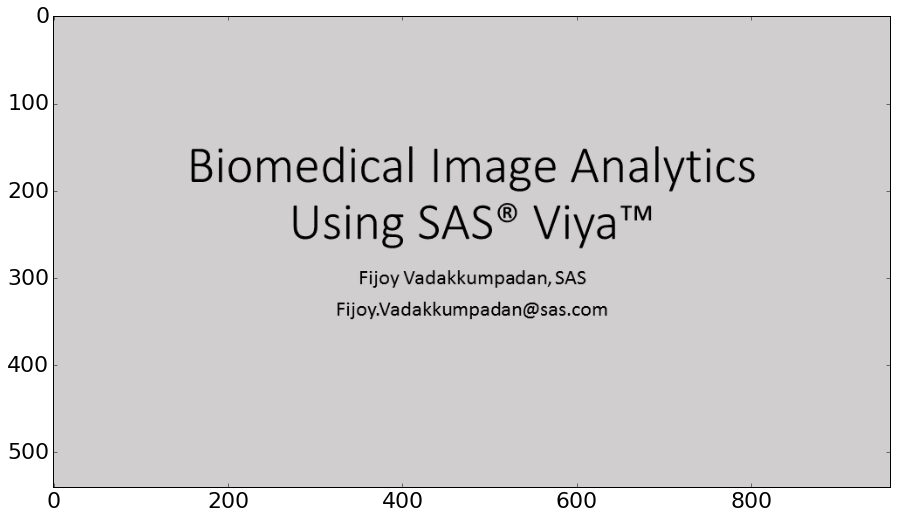

In [161]:
slideBinaries, slidePaths, slideWidth, slideHeight = loadSlides()
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 0)

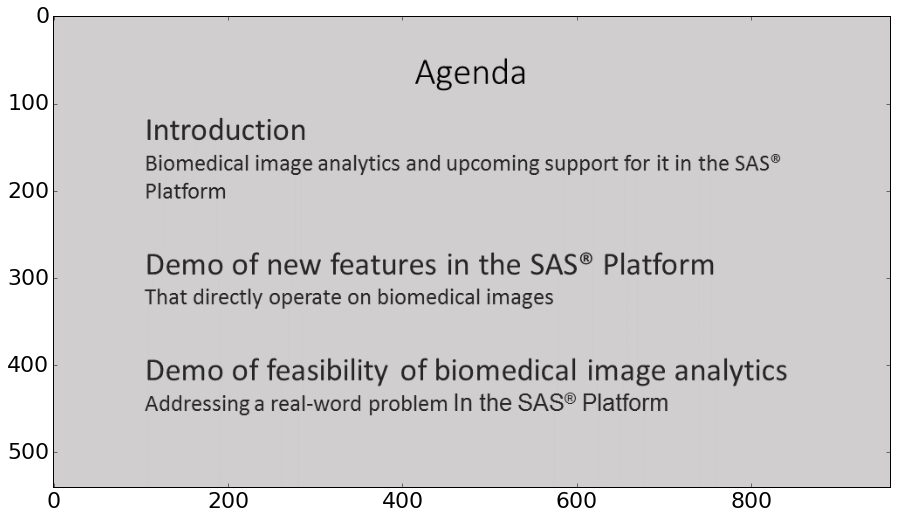

In [162]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 1)

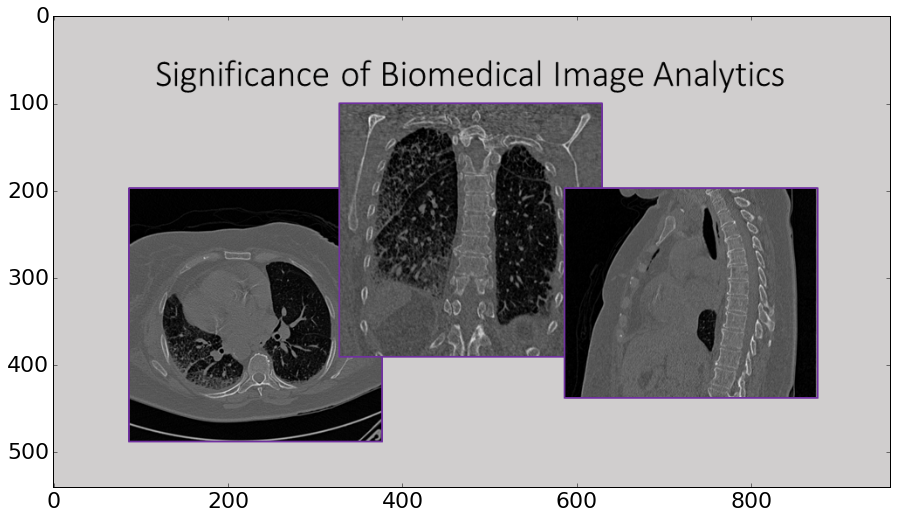

In [163]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 2)

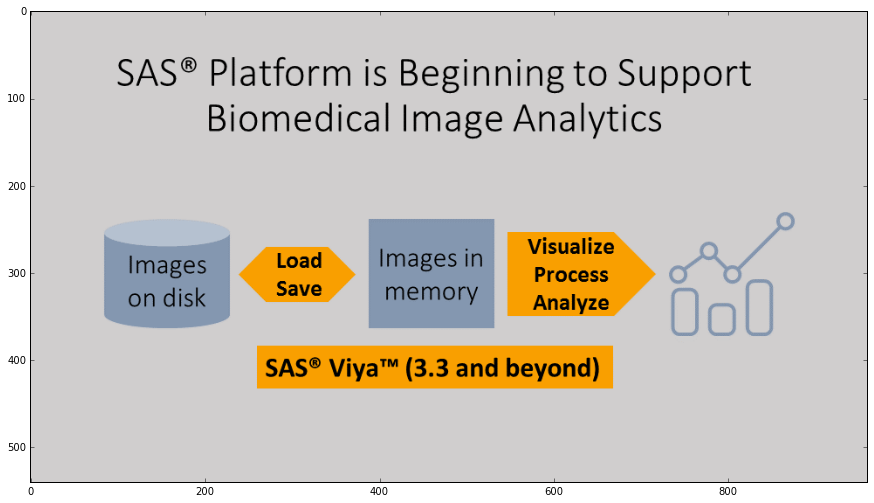

In [115]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 3)

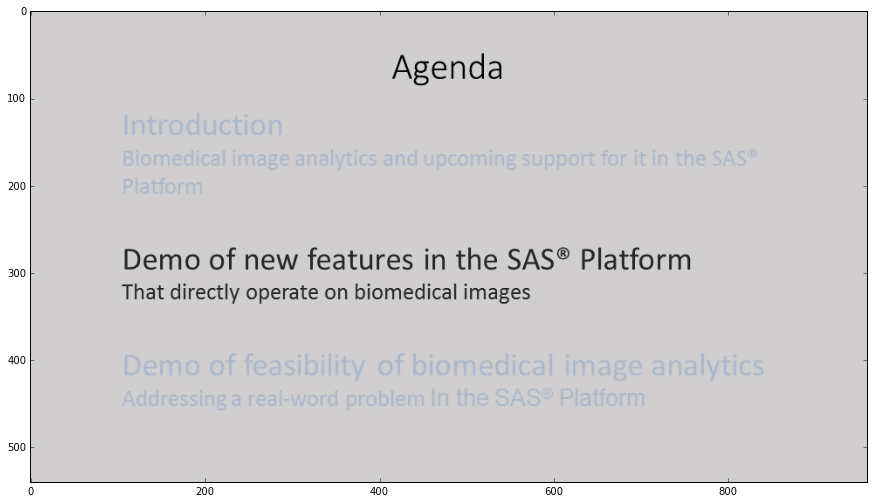

In [116]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 4)

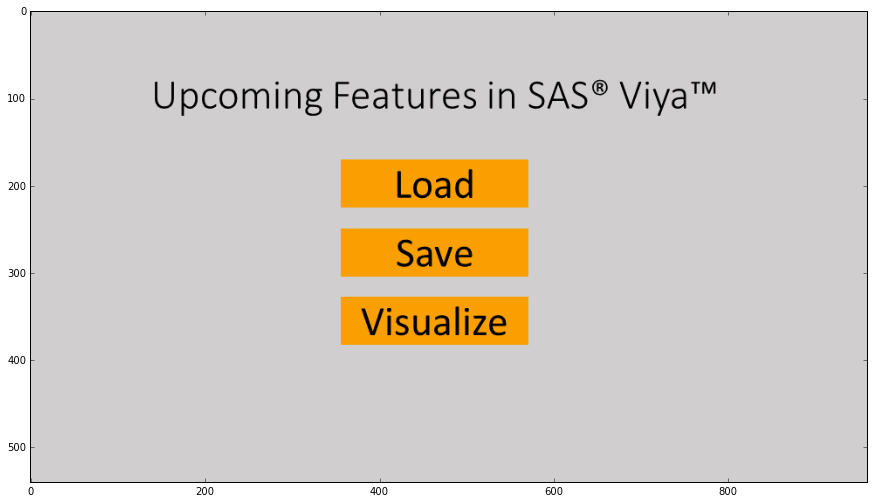

In [118]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 5)

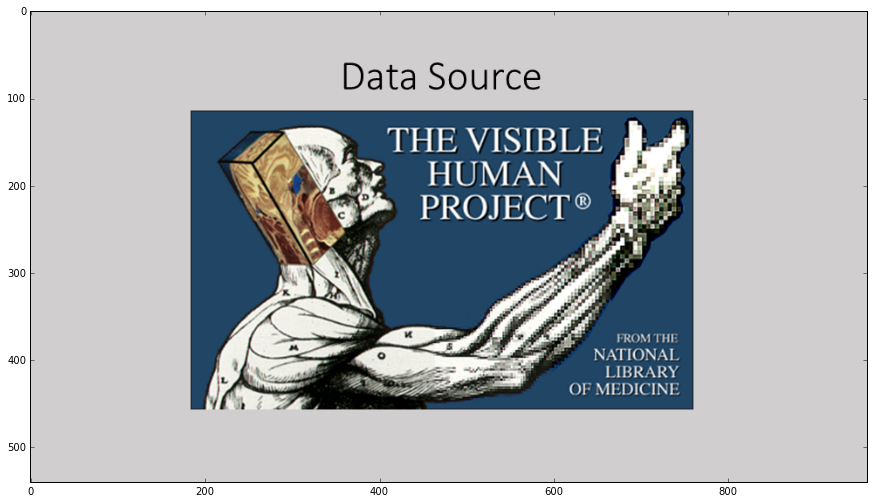

In [119]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 6)

# Load Biomedical Images & Display Metadata: 3D CT Images from Visible Human Project

In [120]:
# Load all image in the Visible Human directory
print('Loading ...', flush=True)
r = s.image.loadImages(path = '/dept/fvcc/BMIData/DemoData/VisibleHuman',
                   casOut=vl(name='vhp', replace='TRUE'),
                   addColumns={"WIDTH", "HEIGHT", "DEPTH", "CHANNELTYPE", "SPACING"},
                   recurse=True,
                   decode=True)

# Fetch images to client side, and display some metadata
print('Fetching ...', flush=True)
vhpRows=s.fetch(table='vhp', sastypes=False,
                fetchVars={'_path_', '_channelType_', '_width_', '_height_', '_depth_', '_spacing_'})['Fetch']
vhpSpacings = vhpRows["_spacing_"]
vhpN = len(vhpRows)
spa=[[], [], []]
for i in range(vhpN):
    spa[i] = ['%.2f' % v for v in struct.unpack('=3d', vhpSpacings[i])]
vhpRows['_spacing_'] = spa
vhpRows['_path_'] = vhpRows['_path_'].str[41:]
print(tabulate(vhpRows.ix[:, ["_path_", "_channelType_", "_width_", "_height_", "_depth_", "_spacing_"]], 
               headers='keys', tablefmt='psql'))

Loading ...
NOTE: Loaded 3 images from /dept/fvcc/BMIData/DemoData/VisibleHuman into Cloud Analytic Services table vhp.
Fetching ...
+----+--------------------------+-----------------+-----------+------------+-----------+--------------------------+
|    | _path_                   | _channelType_   |   _width_ |   _height_ |   _depth_ | _spacing_                |
|----+--------------------------+-----------------+-----------+------------+-----------+--------------------------|
|  0 | Male/frozenCTHead.nii    | 16S             |        93 |        119 |        57 | ['2.10', '2.10', '4.04'] |
|  1 | Male/frozenCTTorso.img   | 16S             |        64 |         45 |       166 | ['4.22', '4.22', '2.67'] |
|  2 | Female/frozenCTAnkle.nii | 16S             |       163 |        236 |        75 | ['1.00', '1.00', '2.00'] |
+----+--------------------------+-----------------+-----------+------------+-----------+--------------------------+


# Fetch & Display Image of the Ankle in Orthogonal View Planes (Using Mayavi)

In [164]:
# Fetch & display the head image
vhpRows=s.fetch(table=vl(name='vhp', where="_path_='" + vhpPath + "Female/frozenCTAnkle.nii'"), 
                         sastypes=False)['Fetch']
medicalDimensions=vhpRows["_dimension_"]
medicalFormats=vhpRows["_channelType_"]
medicalBinaries=vhpRows["_image_"]
medicalResolutions=vhpRows["_resolution_"]
medicalChannelTypes=vhpRows["_channelType_"]
medicalImageArray = getImageArray(medicalBinaries, medicalDimensions, medicalResolutions, medicalFormats, 0)
sf = mlab.pipeline.scalar_field(medicalImageArray)
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes', slice_index=10, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes', slice_index=100, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes', slice_index=50, colormap='gray')
mlab.show()

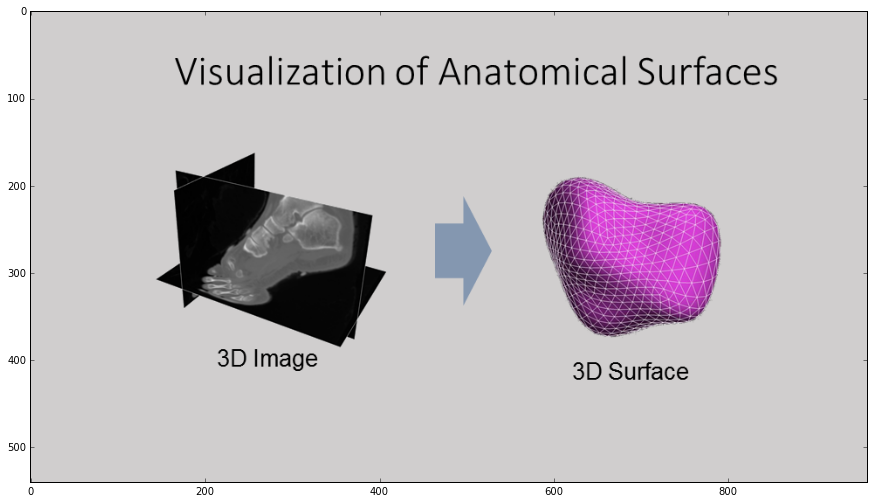

In [122]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 7)

# <font color='green'> (Prerun) </font> Build & Fetch Surfaces from the Images

In [158]:
# Call the build surface action
r = s.biomedimage.buildsurface(images = 'vhp',
                               thresholds=[vl(low=-157, high=1706), vl(low=136, high=1706)],
                               smoothing=vl(iterations=3),
                               outputVertices=vl(name='feetVertices', replace=True),
                               outputFaces=vl(name='feetFaces', replace=True))
display(r)

# Fetch the ankle surface to the client side
surfIds = [6, 13]
print('Fetching the surfaces ...', flush=True)
fetchedVertices = s.fetch(table=vl(name='feetVertices', 
                                   where='_surfaceId_=' + str(surfIds[0]) + ' or ' + '_surfaceId_=' + str(surfIds[1])),
                          sastypes=False, sortBy="_id_", 
                          maxRows=10000000, to=10000000)['Fetch']
fetchedFaces = s.fetch(table='feetFaces', 
                       sastypes=False, maxRows=10000000, to=10000000)['Fetch']


,Surface Identifier,Image Identifier,Low Threshold,High Threshold,Number of Vertices,Number of Faces
0,2,1,-157.0,1706.0,9751,13662
1,5,1,136.0,1706.0,8335,11608
2,4,2,-157.0,1706.0,37715,73518
3,9,2,136.0,1706.0,82417,160626
4,6,3,-157.0,1706.0,137129,273662
5,13,3,136.0,1706.0,162498,323690


Fetching the surfaces ...


# Visualize the Surfaces from the Ankle Image (Using Mayavi)

In [159]:
print('Visualizing the surfaces ...', flush=True)
for surfId in surfIds:
    vertices = fetchedVertices[fetchedVertices._surfaceId_ == surfId]
    faces = fetchedFaces[fetchedFaces._surfaceId_ == surfId]
    x = vertices.ix[:, ["_x_"]]
    y = vertices.ix[:, ["_y_"]]
    z = vertices.ix[:, ["_z_"]]
    flist = faces.ix[:, ["_v1_", "_v2_", "_v3_"]]
    rgb = (255, 255, 255)
    op = 1
    if (surfId == surfIds[0]):
        rgb = (198,134,66)
        op = 0.75
    mlab.triangular_mesh(x, y, z, flist, color=tuple([c/255 for c in rgb]), opacity=op)
mlab.show()

Visualizing the surfaces ...


# Save Biomedical Images in Metaimage Format

In [160]:
# Save images
s.image.saveImages(images = vl(table='vhp', path='_path_'),
                   subdirectory = 'SaveDemo',
                   type = 'mha')

# Confirm that the images were saved
info = get_information(lcdemoPathW + 'SaveDemo')
print(info[0])

['frozenCTHead.mha', 'Thu Nov  9 11:50:24 2017', 'Fri Sep  1 17:26:45 2017']


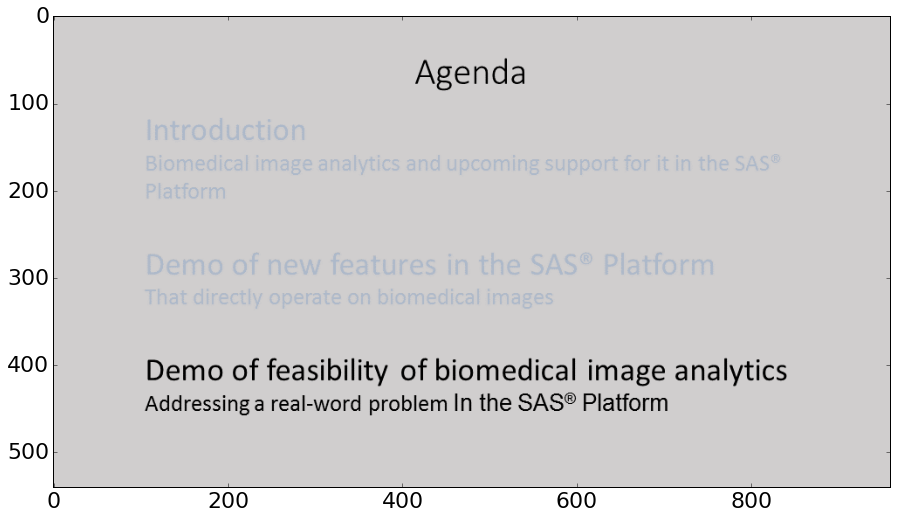

In [165]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 8)

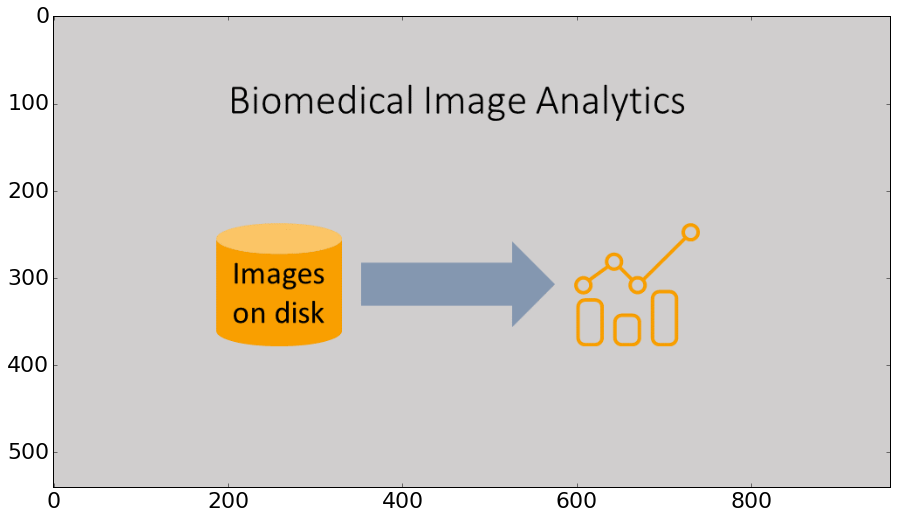

In [166]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 9)

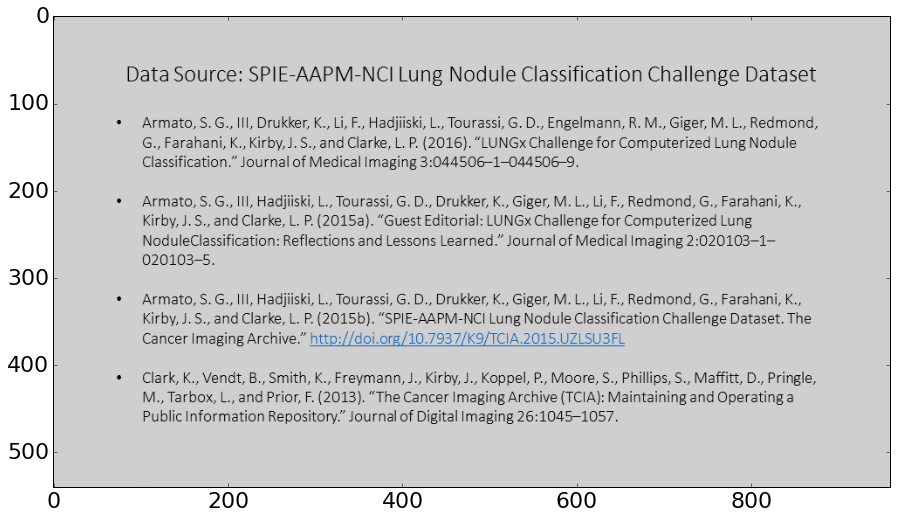

In [167]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 11)

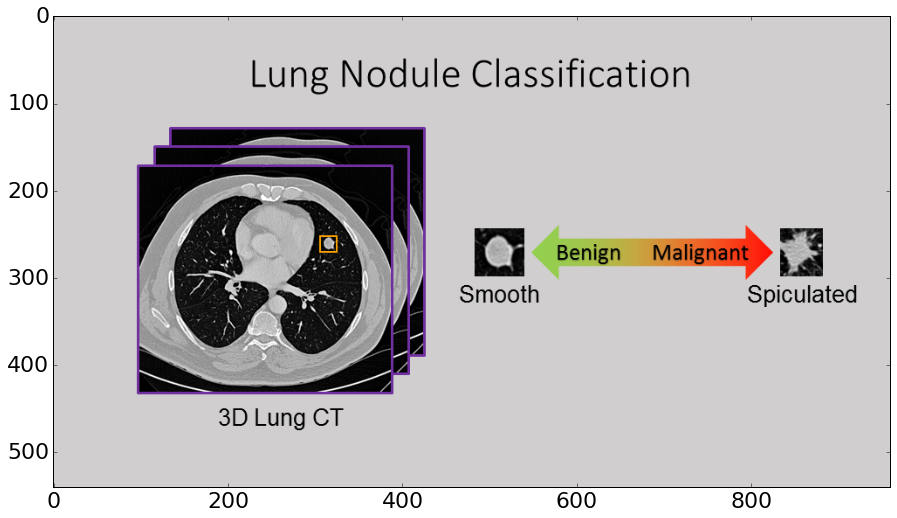

In [168]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 10)

# <font color='green'> (Prerun) </font> Load Example Patient Image with Malignant Lung Nodule (DICOM)

In [130]:
# Load the DICOM series of the patient as a 3D image
pid = 'CT-Training-LC009'
print('Loading the image of ' + pid + ' as DICOM series ...', flush=True)
r = s.image.loadImages(path = lcdemoPath + 'TrainDataOriginal/' + pid,
                   casOut=vl(name='exampleMedical', replace='TRUE'),
                   addColumns={"WIDTH", "HEIGHT", "DEPTH", "CHANNELTYPE"},
                   recurse=True,
                   series=vl(dicom=True),
                   decode=True)

# Fetch the image to client side, and display the image size
print('Fetching the image ...', flush=True)
exampleRows=s.fetch(table='exampleMedical', sastypes=False)['Fetch']

Loading the image of CT-Training-LC009 as DICOM series ...
NOTE: Loaded 1 image from /dept/fvcc/BMIData/DemoData/LungNoduleClassification/TrainDataOriginal/CT-Training-LC009 into Cloud Analytic Services table exampleMedical.
Fetching the image ...


# Display the Example Image

In [169]:
# Display the 3D image
print('Displaying the image ...', flush=True)
print(tabulate(exampleRows.ix[:, ["_channelType_", "_width_", "_height_", "_depth_"]], headers='keys', tablefmt='psql'))
medicalDimensions=exampleRows["_dimension_"]
medicalFormats=exampleRows["_channelType_"]
medicalBinaries=exampleRows["_image_"]
medicalResolutions=exampleRows["_resolution_"]
medicalChannelTypes=exampleRows["_channelType_"]
medicalImageArray = getImageArray(medicalBinaries, medicalDimensions, medicalResolutions, medicalFormats, 0)
sf = mlab.pipeline.scalar_field(medicalImageArray)
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes', slice_index=50, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes', slice_index=100, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes', slice_index=100, colormap='gray')
mlab.show()

Displaying the image ...
+----+-----------------+-----------+------------+-----------+
|    | _channelType_   |   _width_ |   _height_ |   _depth_ |
|----+-----------------+-----------+------------+-----------|
|  0 | 16S             |       512 |        512 |       281 |
+----+-----------------+-----------+------------+-----------+


# Load & Fetch Radiologist Annotations of All Patients

In [170]:
# Load the CSV file with annotations
s.table.loadTable(path = 'trainAnnotations.csv',
                  importoptions = vl(filetype="csv", getNames=True),
                  casout = vl(name='trainlabels', replace=True))

# Fetch it to the client side & display
fetchedLabels=s.fetch(table='trainlabels', sastypes=False, sortBy='PatientID', to=1000000)['Fetch']
nPatients = len(fetchedLabels)
print(tabulate(fetchedLabels, headers='keys', tablefmt='psql'))

# Extract the annotations into separate variables for later use
patientIds = fetchedLabels["PatientID"]
X = fetchedLabels["NoduleX"]
Y = fetchedLabels["NoduleY"]
W = fetchedLabels["NoduleW"]
H = fetchedLabels["NoduleH"]
Z = fetchedLabels["NoduleZ"].copy()
diagnosis = fetchedLabels["Diagnosis"]

+----+-------------------+-----------+-----------+-----------+-----------+-----------+-------------+
|    | PatientID         |   NoduleX |   NoduleY |   NoduleZ |   NoduleW |   NoduleH | Diagnosis   |
|----+-------------------+-----------+-----------+-----------+-----------+-----------+-------------|
|  0 | CT-Training-BE001 |       396 |       288 |       169 |        12 |        12 | benign      |
|  1 | CT-Training-BE007 |       371 |       190 |       194 |        29 |        32 | benign      |
|  2 | CT-Training-LC002 |       132 |       352 |        70 |        14 |        14 | malignant   |
|  3 | CT-Training-LC003 |       365 |       314 |        70 |        19 |        19 | malignant   |
|  4 | CT-Training-LC009 |       129 |       279 |        63 |        39 |        43 | malignant   |
|  5 | LUNGx-CT002       |       311 |       328 |       205 |        37 |        37 | benign      |
|  6 | LUNGx-CT003       |       359 |       359 |       146 |        31 |        31 | mali

# <font color='green'> (Prerun) </font> Load All Patient DICOM Slices & Metadata

In [133]:
# Load all patient images
print('Loading all patient images ...', flush=True)
r = s.image.loadImages(path=lcdemoPath + 'TrainDataOriginal/',
                   casOut=vl(name='origMedical', replace='TRUE'),
                   addColumns={"WIDTH", "HEIGHT", "DEPTH", "CHANNELTYPE", "POSITION", "ORIENTATION", "SPACING"},
                   recurse=True,
                   labelLevels=1,
                   decode=True)
print(r)

Loading all patient images ...
NOTE: Loaded 3374 images from /dept/fvcc/BMIData/DemoData/LungNoduleClassification/TrainDataOriginal/ into Cloud Analytic Services table origMedical.
+ Elapsed: 1.09e+03s, user: 1.02e+03s, sys: 38.8s, mem: 21.5mb
The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


# Fetch & Display Example Slices of a Patient With Correct Position & Orientation

In [171]:
# Fetch example slices for a patient
nSlices = 3
print('Fetching ' + str(nSlices) + ' example slices of ' + pid + ' ...', flush=True)
fetchedRows=s.fetch(table=vl(name='origMedical', where = "_label_='" + pid + "'"), sastypes=False, to=nSlices)['Fetch']

# Display the slices in the patient coordinate system
print('Displaying the slices in the patient coordinate system ...', flush=True)
medicalDimensions=fetchedRows["_dimension_"]
medicalFormats=fetchedRows["_channelType_"]
medicalBinaries=fetchedRows["_image_"]
medicalResolutions=fetchedRows["_resolution_"]
medicalChannelTypes=fetchedRows["_channelType_"]
medicalSpacings=fetchedRows["_spacing_"]
medicalPositions=fetchedRows["_position_"]
medicalOrientations=fetchedRows["_orientation_"]
for i in range(nSlices):
    displaySlice3D(medicalBinaries, medicalDimensions, medicalResolutions, medicalFormats,
                   medicalPositions, medicalOrientations, medicalSpacings, (0, 1, 2), i, 0, 1)
mlab.show()

Fetching 3 example slices of CT-Training-LC009 ...
Displaying the slices in the patient coordinate system ...


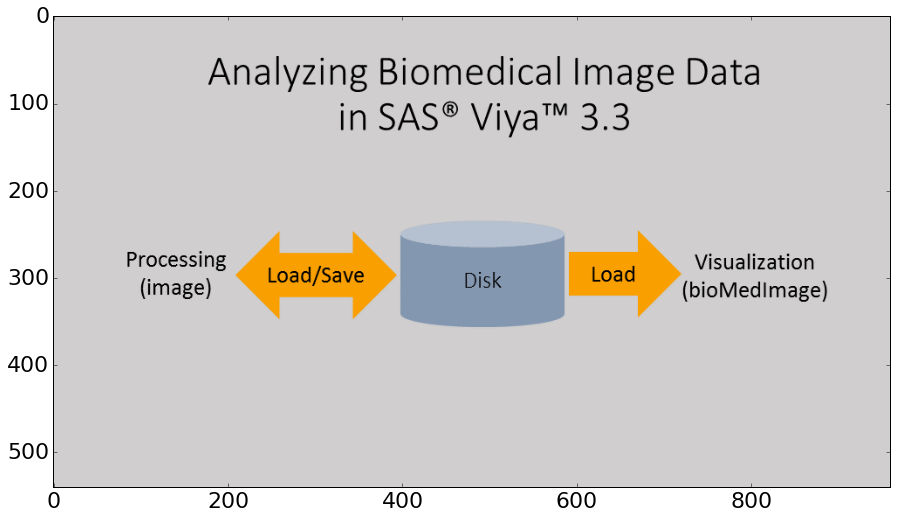

In [172]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 12)

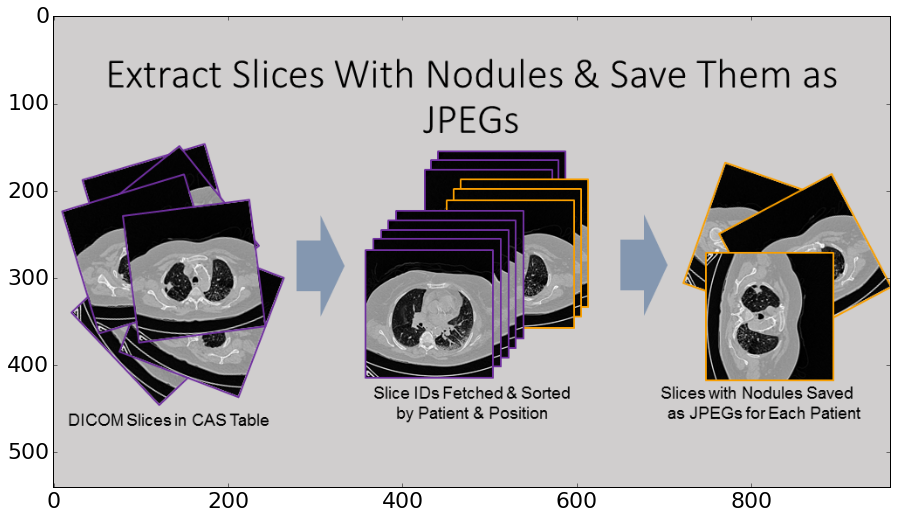

In [173]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 13)

# <font color='green'> (Prerun) </font> 

In [174]:
# Fetch image ids, paths, labels, and geometry metadata
print('Fetching slice ids, paths, labels, and geometry metadata ...', flush=True)
fetchedRows = s.fetch(table='origMedical', 
                      fetchVars={"_id_", "_path_", "_label_", "_position_", "_orientation_", "_spacing_"}, 
                      to=10000000, maxRows=10000000, sastypes=False)['Fetch']
imageIds = fetchedRows["_id_"]
imagePaths = fetchedRows["_path_"]
imageLabels = fetchedRows["_label_"]
imagePositions = fetchedRows["_position_"]
imageOrientations = fetchedRows["_orientation_"]
imageSpacing = fetchedRows["_spacing_"]

# Process each patient
s.setsessopt(messageLevel='NONE')
deltaZ = 5
print('Sorting slice ids & saving ' + str(2*deltaZ+1) + ' nodule slices of ...', flush=True)
for psn in range(len(patientIds)):
    print(patientIds[psn])
    
    # Sort the slices according to position
    sortedInds, _ = sortLabelIdsByPosition(imageIds, imagePaths, imageLabels, imagePositions, imageOrientations, patientIds[psn])
    whereClause = '_id_=' + str(sortedInds[int(Z[psn])-deltaZ])
    
    # Save the slices around the location indicated by the radiologist as JPEGs. Save the patient label also.
    for i in range(-deltaZ+1, deltaZ+1):
        whereClause += ' or _id_=' + str(sortedInds[int(Z[psn])+i])
    res=s.image.saveImages(images=vl(table=vl(name='origMedical', where=whereClause), path='_path_'),
                           caslib=caslibName,
                           subdirectory=lcdemoSubdir + 'TrainDataJPG/',
                           type='jpg',
                           labelLevels=1)
print('All done', flush=True)

Fetching slice ids, paths, labels, and geometry metadata ...
Sorting slice ids & saving 11 nodule slices of ...
CT-Training-BE001
CT-Training-BE007
CT-Training-LC002
CT-Training-LC003
CT-Training-LC009
LUNGx-CT002
LUNGx-CT003
LUNGx-CT009
LUNGx-CT019
LUNGx-CT024
All done


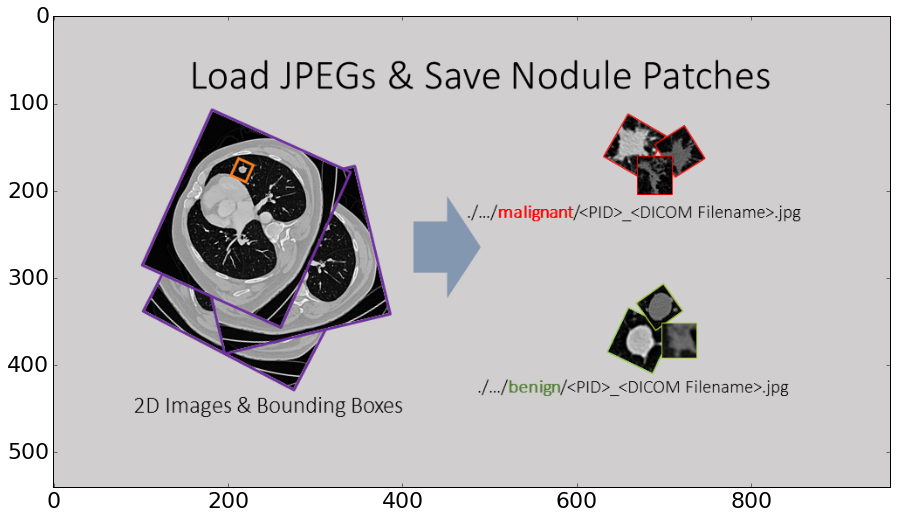

In [176]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 14)

# <font color='green'> (Prerun) </font>

In [139]:
# Process each patient in a loop
testDataJPGPath = lcdemoPath + 'TrainDataJPG'
for i in range(nPatients):
    # Load the JPEGs for this patient
    print('Loading slices of ' + patientIds[i] + ' ...', flush=True)
    s.image.loadImages(path=lcdemoPath + 'TrainDataJPG/' + patientIds[i],
                       casOut=vl(name='jpgMedical', replace='TRUE'))
    
    # Extract the nodule patch using radiologist annotation
    print('Extracting nodule patches ...', flush=True)
    s.image.processImages(imageTable='jpgMedical',
                          casOut=vl(name='cropMedical', replace='TRUE'),
                          imageFunctions=[vl(functionOptions=vl(functionType="GET_PATCH",
                                                                x=int(X[i]), y=int(Y[i]), 
                                                                width=int(W[i]), height=int(H[i])))])
    
    # Save the patches of this patient in benign or maligant folder, with file names containing patient IDs and original
    print('Saving the patches in folder ' + diagnosis[i] + '/ ...', flush=True)
    seriesCropPath = lcdemoSubdir + 'TrainDataJPGCrop/' + diagnosis[i]
    s.image.saveImages(images='cropMedical', caslib=caslibName, 
                       subDirectory=seriesCropPath, prefix=patientIds[i]+'_')
print('All done', flush=True)

Loading slices of CT-Training-BE001 ...
Extracting nodule patches ...
Saving the patches in folder benign/ ...
Loading slices of CT-Training-BE007 ...
Extracting nodule patches ...
Saving the patches in folder benign/ ...
Loading slices of CT-Training-LC002 ...
Extracting nodule patches ...
Saving the patches in folder malignant/ ...
Loading slices of CT-Training-LC003 ...
Extracting nodule patches ...
Saving the patches in folder malignant/ ...
Loading slices of CT-Training-LC009 ...
Extracting nodule patches ...
Saving the patches in folder malignant/ ...
Loading slices of LUNGx-CT002 ...
Extracting nodule patches ...
Saving the patches in folder benign/ ...
Loading slices of LUNGx-CT003 ...
Extracting nodule patches ...
Saving the patches in folder malignant/ ...
Loading slices of LUNGx-CT009 ...
Extracting nodule patches ...
Saving the patches in folder benign/ ...
Loading slices of LUNGx-CT019 ...
Extracting nodule patches ...
Saving the patches in folder malignant/ ...
Loading sl

# Load All Nodule Patches and Corresponding Diagnosis Labels; Display Examples

Loading all nodule patches ...


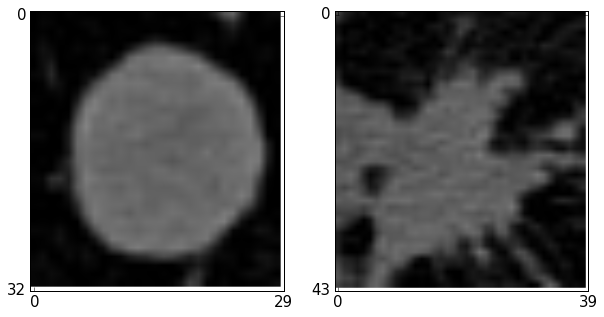

In [177]:
# Load all patches & labels
print('Loading all nodule patches ...', flush=True)
r = s.image.loadImages(casout={'name':'nodules', 'replace':True},
                       path = lcdemoPath + 'TrainDataJPGCrop/',
                       recurse=True,
                       labelLevels = 1,
                       decode=True)

# Display
displayImagePairFromTable('nodules', 3, "_path_='" + lcdemoPath + "TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'", 
                          "_path_='" + lcdemoPath + "TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'")

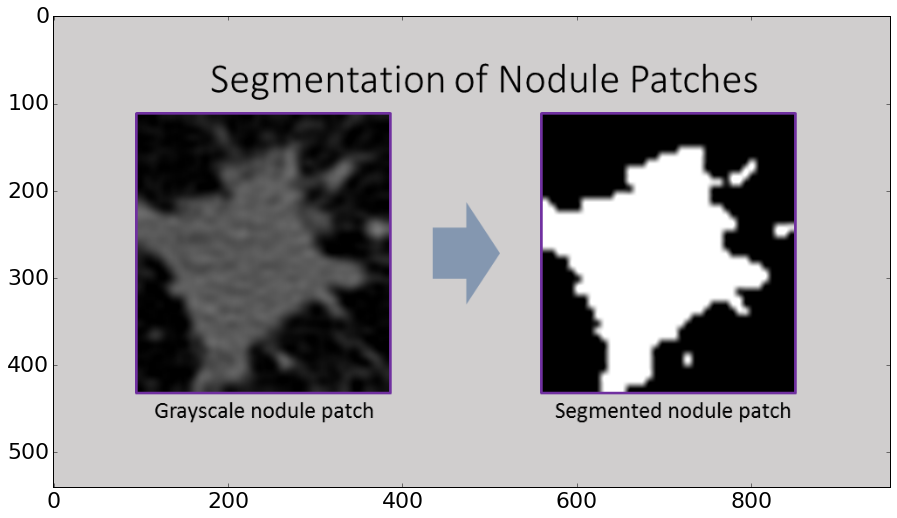

In [178]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 15)

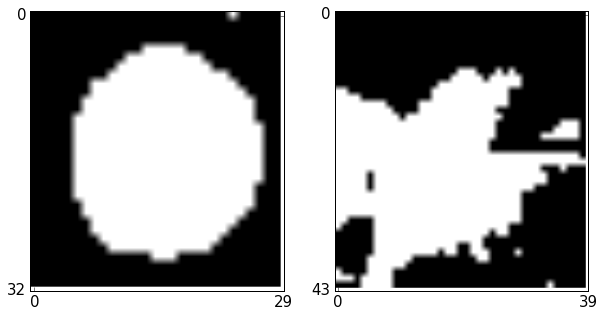

In [179]:
# Call smoothing and thresholding via processImages action
r = s.image.processImages(casout={'name':'masks','replace':True},
        imagetable={'name':'nodules'},
        imagefunctions=[
            {'options':{'functiontype':'CONVERT_COLOR'}}, #change color space to grayscale
        
            {'options':{'functiontype':'BILATERAL_FILTER', #noise reduction
                        'diameter':13,'sigmacolor':30,'sigmaspace':30}},
        
            {'options':{'functiontype':'THRESHOLD', #image binarization
                        'type':'OTSU','value':125}}],
        copyVars={'_path_', '_label_'},
        decode=True)

# Display
displayImagePairFromTable('masks', 1, "_path_='" + lcdemoPath + "TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'", 
                          "_path_='" + lcdemoPath + "TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'")

# Visualize Nodules Along with Ragiologist Annotated Slice, in 3D

In [180]:
# Function for visualizing the nodule of a patient, along with radiologist annotated slice, in 3D
def VisualizeNodule(masksTableName, psn):
    # Save the segmented nodule patches in order, as PNG images
    print('Saving segmented nodule slices with order embedded into file names ...', flush=True)
    cropPath = lcdemoPath + 'TrainDataJPGCrop/'
    plbl = patientIds[psn]
    pdia = diagnosis[psn]
    sortedIds, sortedPaths = sortLabelIdsByPosition(imageIds, imagePaths, imageLabels, imagePositions, imageOrientations, plbl)
    pathToSave = cropPath + pdia + '/' + plbl + '_' + sortedPaths[int(Z[psn])-deltaZ+1].rsplit('/', 1)[1][0:6] + '.jpg'
    pgm = "length _newPath_ varchar(*); " + \
          "if _path_ = '" + pathToSave + "' then " + \
              "_newPath_ = '/001.tif'; "
    count = 2
    for i in range(-deltaZ+2, deltaZ+1):
        pathToSave = cropPath + pdia + '/' + plbl + '_' + sortedPaths[int(Z[psn])+i].rsplit('/', 1)[1][0:6] + '.jpg'
        pgm +=  "else if _path_ = '" + pathToSave + "' then " + \
                    "_newPath_ = '/" + '%03d.tif' % count + "'; "
        count += 1
    pgm += "else _newPath_ = '/dummy';"
    s.image.saveImages(images=vl(table=vl(name=masksTableName, computedVars = {"_newPath_"}, computedVarsProgram=pgm,), 
                                           path='_newPath_'),
                           caslib=caslibName, subdirectory=lcdemoSubdir + 'ForVisualization/' + plbl)
    
    # Load the nodule patches in order into a 3D image
    print('Loading the saved slides as a series into a 3D image ...', flush=True)
    s.image.loadImages(path = lcdemoPath + 'ForVisualization/' + plbl,
                       casout = vl(name='mask3D', replace=True),
                       series=vl(dicom=False))
    
    # Build the surface for the nodule
    print('Building 3D surface of the nodule ...', flush=True)
    resultTab = s.biomedimage.buildSurface(images = 'mask3D',
                                           intensities = {255},
                                           smoothing=vl(iterations=1),
                                           nThreads=1,
                                           outputVertices = vl(name='vertices', replace='TRUE'),
                                           outputFaces = vl(name='faces', replace='TRUE'))
    display(resultTab)
    
    # Fetch the surface to the client side
    print('Fetching the surface ...', flush=True)
    fetchedVertices = s.fetch(table='vertices', 
                              sastypes=False, sortBy="_id_", 
                              maxRows=10000000, to=10000000)['Fetch']
    fetchedFaces = s.fetch(table='faces', 
                           sastypes=False, maxRows=10000000, to=10000000)['Fetch']
    vertices = fetchedVertices[fetchedVertices._surfaceId_ == 2]
    faces = fetchedFaces[fetchedFaces._surfaceId_ == 2]
    x = vertices.ix[:, ["_x_"]]
    y = vertices.ix[:, ["_y_"]]
    z = vertices.ix[:, ["_z_"]]
    flist = faces.ix[:, ["_v1_", "_v2_", "_v3_"]]
    
    # Fetch the radiologist annotated slice and its metadata
    print('Fetching radiologist annotated slice and metadata ...', flush=True)
    slicePath = sortedPaths[int(Z[psn])]
    fetchedRows = s.fetch(table=vl(name='origMedical', where="_path_='" + slicePath + "'"), 
                          sastypes=False)['Fetch']
    sliceImage = fetchedRows["_image_"]
    sliceDimension = fetchedRows["_dimension_"]
    sliceResolution = fetchedRows["_resolution_"]
    sliceFormat = fetchedRows["_channelType_"]
    slicePosition = fetchedRows["_position_"]
    sliceOrientation = fetchedRows["_orientation_"]
    sliceSpacing = fetchedRows["_spacing_"]

    # Linearly transform the surface to match the slice's coordinate system
    print('Linearly transforming the surface into the same coordinate system as the slice ...', flush=True)
    V = np.vstack((np.array(x).T, np.array(y).T, np.array(z).T))
    C = np.array([X[psn], Y[psn], -deltaZ])
    C.shape = (3, 1)
    O = np.array(struct.unpack('=3d', slicePosition[0]))
    O.shape = (3, 1)
    S = np.array(struct.unpack('=3d', sliceSpacing[0]))
    S = np.diag(S)
    R = np.array(struct.unpack('=9d', sliceOrientation[0]))
    R.shape = (3, 3)
    P = O + np.matmul(R, np.matmul(S, V+C))
    
    return sliceImage, sliceDimension, sliceResolution, sliceFormat, slicePosition, sliceOrientation, sliceSpacing, P, flist

# <font color='green'> (Prerun) </font> Prepare for Visualizations

In [144]:
sib, sdb, srb, sfb, spb, sob, ssb, Pb, flistb = VisualizeNodule('masks', 1)
sim, sdm, srm, sfm, spm, som, ssm, Pm, flistm = VisualizeNodule('masks', 4)

Saving segmented nodule slices with order embedded into file names ...
Loading the saved slides as a series into a 3D image ...
Building 3D surface of the nodule ...


,Surface Identifier,Image Identifier,Low Threshold,High Threshold,Number of Vertices,Number of Faces
0,2,1,255.0,255.0,2093,3656


Fetching the surface ...
Fetching radiologist annotated slice and metadata ...
Linearly transforming the surface into the same coordinate system as the slice ...
Saving segmented nodule slices with order embedded into file names ...
Loading the saved slides as a series into a 3D image ...
Building 3D surface of the nodule ...


,Surface Identifier,Image Identifier,Low Threshold,High Threshold,Number of Vertices,Number of Faces
0,2,1,255.0,255.0,5302,9400


Fetching the surface ...
Fetching radiologist annotated slice and metadata ...
Linearly transforming the surface into the same coordinate system as the slice ...


# Visualize a Benign Nodule

In [181]:
displaySlice3D(sib, sdb, srb, sfb, spb, sob, ssb, (0, 1, 2), 0, 0, 1)
mlab.triangular_mesh(Pb[0, :], Pb[1, :], Pb[2, :], flistb, color=tuple([c/255 for c in (0, 255, 0)]), opacity=0.5)
mlab.show()

# Visualize a Malignant Nodule

In [182]:
displaySlice3D(sim, sdm, srm, sfm, spm, som, ssm, (0, 1, 2), 0, 0, 1)
mlab.triangular_mesh(Pm[0, :], Pm[1, :], Pm[2, :], flistm, color=tuple([c/255 for c in (255, 0, 0)]), opacity=0.5)
mlab.show()

# Resample All Patches to 32x32

In [183]:
# Calling processImages
commonW = 32
commonH = 32
s.image.processImages(imageTable='masks', 
                      casOut=vl(name='masksScaled', replace='TRUE'),
                      imageFunctions=[vl(functionOptions=vl(functionType="RESIZE", width=commonW, 
                                                            height=commonH)),
                                      vl(functionOptions=vl(functionType="THRESHOLD", type="BINARY", 
                                                            value=128))],
                      copyVars={'_path_', '_label_'},
                      decode=True)

+ Elapsed: 0.005s, user: 0.005s, sys: 0.002s, mem: 66.8mb

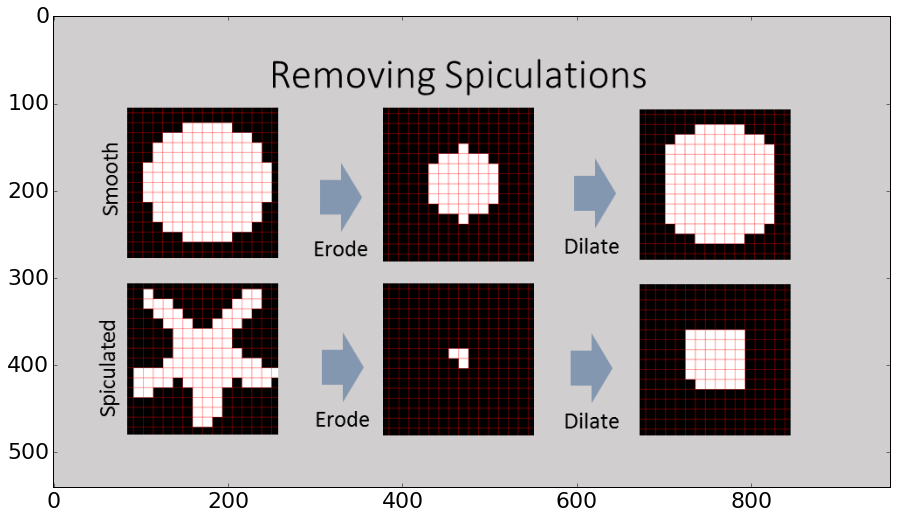

In [184]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 16)

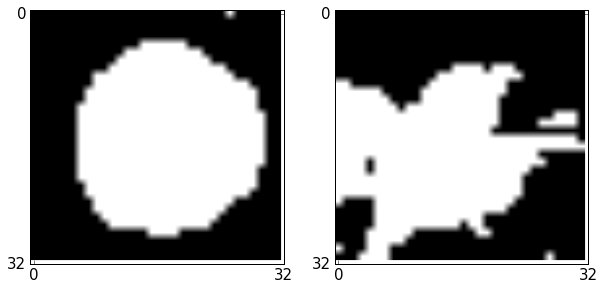

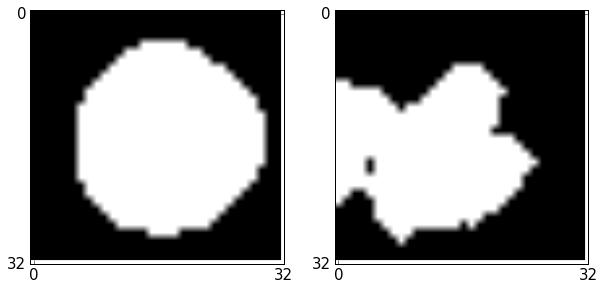

In [185]:
# Erosion and dilation using processImages
s.image.processImages(imageTable='masksScaled', 
                      casOut=vl(name='masksFinal', replace='TRUE'),
                      imageFunctions=[vl(functionOptions=vl(functionType="MORPHOLOGY", method="ERODE",
                                                            kernelWidth=3, KernelHeight=3)),
                                      vl(functionOptions=vl(functionType="MORPHOLOGY", method="ERODE",
                                                            kernelWidth=3, KernelHeight=3)),
                                      vl(functionOptions=vl(functionType="MORPHOLOGY", method="ERODE",
                                                            kernelWidth=3, KernelHeight=3)),
                                      vl(functionOptions=vl(functionType="MORPHOLOGY", method="DILATE",
                                                            kernelWidth=3, KernelHeight=3)),
                                      vl(functionOptions=vl(functionType="MORPHOLOGY", method="DILATE",
                                                            kernelWidth=3, KernelHeight=3)),
                                      vl(functionOptions=vl(functionType="MORPHOLOGY", method="DILATE",
                                                            kernelWidth=3, KernelHeight=3))],
                      copyVars={'_path_', '_label_'},
                      decode=True)

# Display
displayImagePairFromTable('masksScaled', 1, "_path_='" + lcdemoPath + "TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'", 
                          "_path_='" + lcdemoPath + "TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'")
displayImagePairFromTable('masksFinal', 1, "_path_='" + lcdemoPath + "TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'", 
                          "_path_='" + lcdemoPath + "TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'")

# Convert Before & After Images to Wide Format

In [186]:
# Convert before & after images to color
s.image.processImages(imageTable='masksScaled', 
                      casOut=vl(name='masksScaledColor', replace='TRUE'),
                      imageFunctions=[vl(functionOptions=vl(functionType="CONVERT_COLOR", type="GRAY2COLOR"))],
                      copyVars={'_path_', '_label_'},
                      decode=True)

s.image.processImages(imageTable='masksFinal', 
                      casOut=vl(name='masksFinalColor', replace='TRUE'),
                      imageFunctions=[vl(functionOptions=vl(functionType="CONVERT_COLOR", type="GRAY2COLOR"))],
                      copyVars={'_path_', '_label_'},
                      decode=True)

# Convert before & after images to wide format
s.image.flattenImageTable(imageTable='masksScaledColor',
                          casOut=vl(name='masksScaledFlat', replace='TRUE'),
                          width=commonW,
                          height=commonH)

s.image.flattenImageTable(imageTable='masksFinalColor', 
                          casOut=vl(name='masksFinalFlat', replace='TRUE'),
                          width=commonW,
                          height=commonH)

# Fetch sample rows to the client side & display
fetchedFlat=s.fetch(table='masksScaledFlat', sastypes=False, to=3)['Fetch']
print('--- BEFORE morphological operations ---')
fetchedFlat['_path_'] = fetchedFlat['_path_'].str[65:]
midc = 'c1017'
print(tabulate(fetchedFlat.ix[:, ['_path_', 'c1', 'c2', 'c3', midc, 'c3072', '_label_']], headers='keys', tablefmt='psql'))
fetchedFlat=s.fetch(table='masksFinalFlat', sastypes=False, to=3)['Fetch']
print('\n--- AFTER morphological operations ---')
fetchedFlat['_path_'] = fetchedFlat['_path_'].str[65:]
print(tabulate(fetchedFlat.ix[:, ['_path_', 'c1', 'c2', 'c3', midc, 'c3072', '_label_']], headers='keys', tablefmt='psql'))

--- BEFORE morphological operations ---
+----+---------------------------------------------+------+------+------+---------+---------+-----------+
|    | _path_                                      |   c1 |   c2 |   c3 |   c1017 |   c3072 | _label_   |
|----+---------------------------------------------+------+------+------+---------+---------+-----------|
|  0 | Crop/malignant/CT-Training-LC003_000025.jpg |    0 |    0 |    0 |     255 |       0 | malignant |
|  1 | Crop/malignant/CT-Training-LC003_000007.jpg |    0 |    0 |    0 |     255 |     255 | malignant |
|  2 | Crop/malignant/CT-Training-LC002_000042.jpg |    0 |    0 |    0 |       0 |       0 | malignant |
+----+---------------------------------------------+------+------+------+---------+---------+-----------+

--- AFTER morphological operations ---
+----+---------------------------------------------+------+------+------+---------+---------+-----------+
|    | _path_                                      |   c1 |   c2 |   c3 

# Add Up the White Pixels in All Images & Fetch the Results

In [187]:
# Create the program for sum of all columns
pgm = "nz = c1";
for num in range(2, commonW*commonH*3 + 1):
    pgm += "+c" + str(num)
    

# Fetch the tables with #white pixels in each of the slices computed
scaledSum = s.fetch(table=vl(name = 'masksScaledFlat', computedVars = {"nz"}, computedVarsProgram=pgm),
                    fetchVars={'_path_', '_label_', 'nz'},
                    to = 1000)['Fetch']

finalSum = s.fetch(table=vl(name = 'masksFinalFlat', computedVars = {"nz"}, computedVarsProgram=pgm),
                   fetchVars={'_path_', 'nz'},
                   to = 1000)['Fetch']

# Fetch sample rows to the client side & display
print('--- BEFORE morphological operations ---')
scaledSum['_path_'] = scaledSum['_path_'].str[65:]
print(tabulate(scaledSum.ix[0:2, ['_path_', 'nz', '_label_']], headers='keys', tablefmt='psql'))
print('\n--- AFTER morphological operations ---')
finalSum['_path_'] = finalSum['_path_'].str[65:]
print(tabulate(finalSum.ix[0:2, ['_path_', 'nz']], headers='keys', tablefmt='psql'))

--- BEFORE morphological operations ---
+----+---------------------------------------------+--------+-----------+
|    | _path_                                      |     nz | _label_   |
|----+---------------------------------------------+--------+-----------|
|  0 | Crop/malignant/CT-Training-LC003_000025.jpg | 262395 | malignant |
|  1 | Crop/malignant/CT-Training-LC003_000007.jpg | 250920 | malignant |
|  2 | Crop/malignant/CT-Training-LC002_000042.jpg | 207315 | malignant |
+----+---------------------------------------------+--------+-----------+

--- AFTER morphological operations ---
+----+---------------------------------------------+--------+
|    | _path_                                      |     nz |
|----+---------------------------------------------+--------|
|  0 | Crop/malignant/CT-Training-LC003_000025.jpg | 244035 |
|  1 | Crop/malignant/CT-Training-LC003_000007.jpg | 225675 |
|  2 | Crop/malignant/CT-Training-LC002_000042.jpg | 108630 |
+----+------------------------

# Compute Degree of Spiculation: Relative Amount of Pixels "Lost" During Morphological Operations

In [188]:
# Join the 2 tables on file path
joinedSum = pd.merge(scaledSum, finalSum, on = '_path_', suffixes = ['s', 'f'])
fetchedSpiculations = (joinedSum['nzs'] - joinedSum['nzf'])/joinedSum['nzs']
fetchedLabels = joinedSum['_label_']
nImages = len(fetchedLabels)
print(np.column_stack((fetchedSpiculations, fetchedLabels.T))[0:3, :])

[[0.06997084548104957 'malignant']
 [0.10060975609756098 'malignant']
 [0.47601476014760147 'malignant']]


# Plot the Distribution of Degree of Spiculation for Each Class

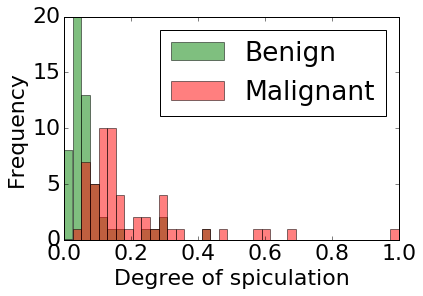

In [189]:
# Plot histograms for spiculation for each label
fig, ax = plt.subplots()
bar_width = 0.7
opacity = 0.5
bins = np.linspace(0, 1, 40)
inds = [i for i in range(nImages) if fetchedLabels[i] == 'benign']
plt.hist(fetchedSpiculations[inds], bins, alpha=opacity, label='Benign', color='g')
inds = [i for i in range(nImages) if fetchedLabels[i] == 'malignant']
plt.hist(fetchedSpiculations[inds], bins, alpha=opacity, label='Malignant', color='r')
plt.xlabel('Degree of spiculation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot ROC Curve for the Metric & Calculate Optimal Threshold

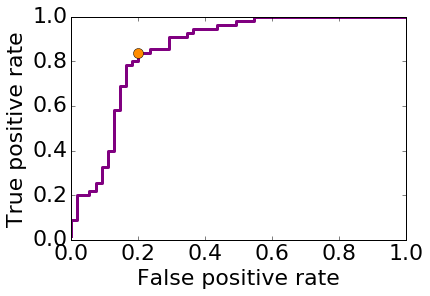

Optimal spiculation cut off: 0.0797720797721


In [190]:
optt, fpr, tpr, thresholds = Find_Optimal_Cutoff(fetchedLabels, fetchedSpiculations, 'malignant')
plt.plot(fpr, tpr, color='#800080', linewidth=3.0)

plt.plot([fpr[i] for i in range(len(thresholds)) if thresholds[i] == optt[0]], 
         [tpr[i] for i in range(len(thresholds)) if thresholds[i] == optt[0]], marker='o', color='#FF8C00', markersize=10)
matplotlib.rcParams.update({'font.size': 22})
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
print('Optimal spiculation cut off: ' + str(optt[0]))

# Assess the Metric Accuracy With k-Fold Cross Validation

In [191]:
nFolds = 10;
kf = model_selection.KFold(n_splits=nFolds)
acc=[]
for train_index, test_index in kf.split(fetchedSpiculations):
    ot, f, t, ts = Find_Optimal_Cutoff(fetchedLabels[train_index], fetchedSpiculations[train_index], 'malignant')
    acc.extend([sum(1 for i in test_index if (fetchedSpiculations[i]>ot and fetchedLabels[i]=='malignant') or
                                             (fetchedSpiculations[i]<=ot and fetchedLabels[i]=='benign'))/len(test_index)*100])
print('Classification accuracy based on ' + str(nFolds) + '-fold cross-validation: ' + str(np.mean(acc)))

Classification accuracy based on 10-fold cross-validation: 78.1818181818


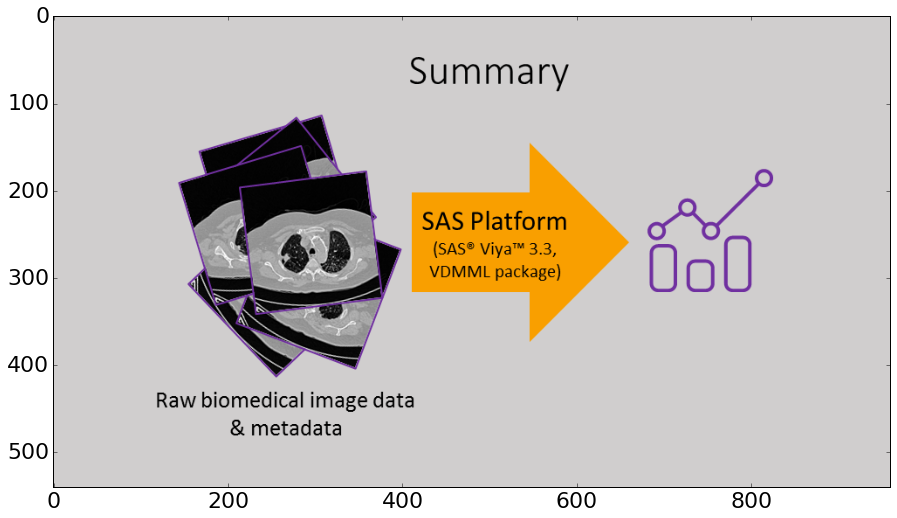

In [192]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 17)

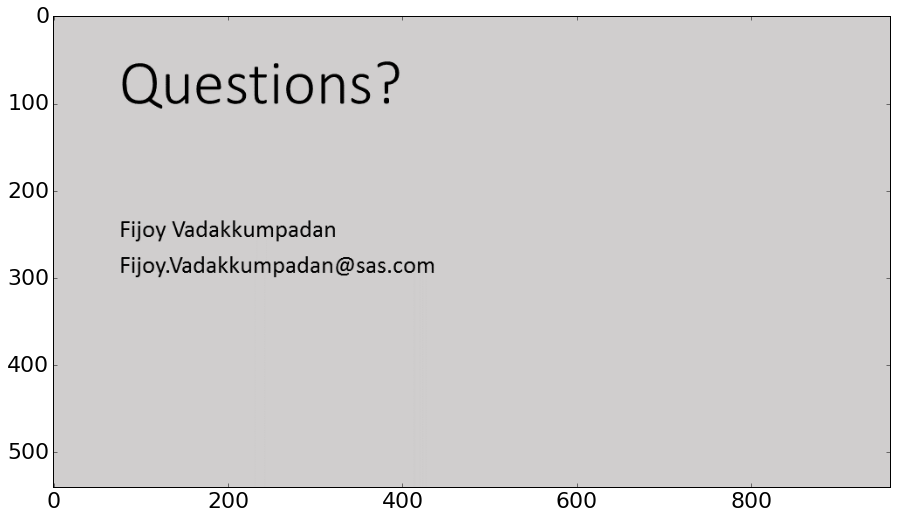

In [193]:
displaySlide(slideBinaries, slidePaths, slideWidth, slideHeight, 18)